# 3x3 assembly inputfile that: 

### Import module/Set up XS path/Create openMC model/Clean directory

In [1]:
import sys
import os 
import openmc
import numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs
import pandas as pd
from IPython.display import Image
import glob

### Ragusa environnement

import os

# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'
os.environ['PATH'] += r':/Users/jean.ragusa/repo/openmc/local/bin'

# Add location of OpenMC xs data
%env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml
# %env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/nndc_hdf5/cross_sections.xml

### Pablo environnement

In [2]:
%env OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml
model=openmc.Model()

clean_file_list = ["model.xml", "materials.xml", "geometry.xml","plots.xml","geometry.xml","settings.xml","tallies.out","summary.h5","statepoint.50.h5"]

for file in clean_file_list :
    path_file = os.path.join(os.getcwd(), file)
    if os.path.exists(path_file):
        os.remove(path_file)



env: OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml


### Define Materials

In [3]:
uo2 = openmc.Material(name='uo2')
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)
zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)
water = openmc.Material(name="water")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

    
model.materials = openmc.Materials([uo2, zirconium, water]) 
model.materials.cross_sections = '/home/pablo/internship/xs_for_input/cross_sections.xml'

model.materials.export_to_xml()

### Create pincell

In [4]:
def pincell(index_x,index_y):
    fuel_outer_radius = openmc.ZCylinder(r=0.39)
    clad_inner_radius = openmc.ZCylinder(r=0.40)
    clad_outer_radius = openmc.ZCylinder(r=0.46)
    pitch = 1.26
    
    left = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right = openmc.XPlane(pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top = openmc.YPlane(pitch/2, boundary_type='transmission')
    
    fuel_region = -fuel_outer_radius
    gap_region = +fuel_outer_radius & -clad_inner_radius
    clad_region = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    
    fuel = openmc.Cell(name='fuel'+'_'+str(index_x)+'_'+str(index_y))
    fuel.fill = uo2
    fuel.region = fuel_region
    gap = openmc.Cell(name='gap'+'_'+str(index_x)+'_'+str(index_y))
    gap.region = gap_region
    clad = openmc.Cell(name='clad'+'_'+str(index_x)+'_'+str(index_y))
    clad.fill = zirconium
    clad.region = clad_region
    moderator = openmc.Cell(name='moderator'+'_'+str(index_x)+'_'+str(index_y))
    moderator.fill = water
    moderator.region = water_region
    
    u = openmc.Universe(name='u'+'_'+str(index_x)+'_'+str(index_y),cells=(fuel, gap, clad, moderator))
    return(u,fuel,gap,clad,moderator)

### Create guide tube

In [5]:
def guide(index_x,index_y):
    
    clad_inner_radius = openmc.ZCylinder(r=0.5610)
    clad_outer_radius = openmc.ZCylinder(r=0.6020)
    pitch = 1.26
    
    left = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right = openmc.XPlane(pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top = openmc.YPlane(pitch/2, boundary_type='transmission')
    
    
    
    clad_region = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    water_guide_region= -clad_inner_radius

    water_guide = openmc.Cell(name='water_guide'+'_'+str(index_x)+'_'+str(index_y))
    water_guide.fill = water
    water_guide.region = water_guide_region
    clad = openmc.Cell(name='clad_guide'+'_'+str(index_x)+'_'+str(index_y))
    clad.fill = zirconium
    clad.region = clad_region
    moderator = openmc.Cell(name='moderator'+'_'+str(index_x)+'_'+str(index_y))
    moderator.fill = water
    moderator.region = water_region
    
    u = openmc.Universe(name='u_guide'+'_'+str(index_x)+'_'+str(index_y),cells=(water_guide, clad, moderator))
    return(u,water_guide,water_guide,clad,moderator)

### Define assembly

In [6]:
assembly = openmc.RectLattice()
pitch=1.26

dr=2e-1 # cm of water that is outside assembly
size=1 #size of the assembly 
pitch_assembly=size*pitch+2*dr #(17x1,26)
assembly.pitch = (pitch,pitch)

assembly.lower_left = (-size/2*pitch, -size/2*pitch)

# Template for guide tube position 
# template_x = np.array([1])
# template_y = np.array([1])


#template 17x17
template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8,
                           11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8,
                           8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])



A= np.empty((size, size), dtype=openmc.universe.Universe)

for ix in range(size):
    for iy in range(size):
        indices_x = np.where(template_x == ix)[0]
        indices_y = np.where(template_y == iy)[0]
        if any(i in indices_y for i in indices_x):
            A[ix][iy]=guide(ix,iy)[0]
        else:
            A[ix][iy]=pincell(ix,iy)[0]

        
assembly.universes = A

moderator_outside = openmc.Cell()
moderator_outside.fill = water
all_water = openmc.Universe()
all_water.add_cell(moderator_outside)
assembly.outer=all_water


# full assembly
# min_x = openmc.XPlane(x0=-pitch_assembly/2, boundary_type='reflective')
# max_x = openmc.XPlane(x0=+pitch_assembly/2, boundary_type='reflective')
# min_y = openmc.YPlane(y0=-pitch_assembly/2, boundary_type='reflective')
# max_y = openmc.YPlane(y0=+pitch_assembly/2, boundary_type='reflective')
# min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
# max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

# 1/4 assembly
min_x = openmc.XPlane(x0=-(size/2*pitch+dr), boundary_type='reflective')
max_x = openmc.XPlane(x0=0, boundary_type='reflective')
min_y = openmc.YPlane(y0=0, boundary_type='reflective')
max_y = openmc.YPlane(y0=+(size/2*pitch+dr), boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')


root_cell = openmc.Cell(name='root cell', fill=assembly)
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

model.geometry.root_universe = openmc.Universe(name='root universe')
model.geometry.root_universe.add_cell(root_cell)

model.geometry.export_to_xml()

### Plot assembly

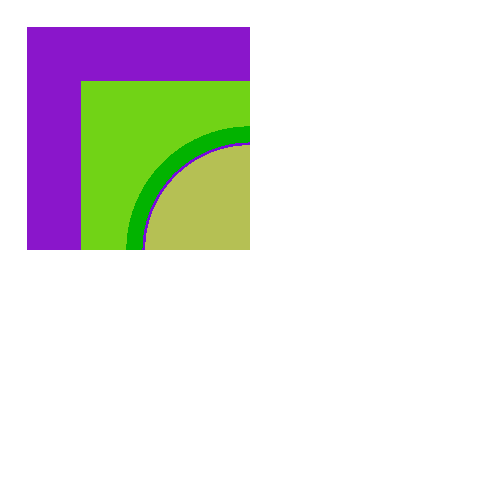

In [7]:
plot = openmc.Plot.from_geometry(model.geometry)
plot.pixels = (500, 500)
plot.width = (pitch_assembly+dr, pitch_assembly+dr)
plot.origin = (0., 0., 0)
plot.color_by = 'cell'
# plot.colors = {
#     water: 'blue',
#     zirconium: 'black',
#     helium: 'yellow',
#     uo2_in: (100, 0, 0),
#     uo2_out: (255, 0, 0)
# }
plot.to_ipython_image()

### Choose settings

In [8]:


bounds = [-pitch_assembly/2, 0, -10, 0, +pitch_assembly/2, 10]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
source = openmc.IndependentSource(space=uniform_dist)

# source = openmc.IndependentSource()
# source.space = openmc.stats.Point((0.1,0.1,0.))
# source.angle = openmc.stats.Isotropic()
# source.energy = openmc.stats.Discrete([10.0e6], [1.0])
source.time = openmc.stats.Uniform(0, 1e-6)
settings = openmc.Settings()
settings.source = source
settings = openmc.Settings()
settings.source = source
settings.batches = 50
settings.inactive = 10
settings.particles = 5000
settings.output = {'tallies':True}
model.settings = settings
model.settings.export_to_xml()

### Define and choose energy group

In [9]:
choose_group=openmc.mgxs.GROUP_STRUCTURES['XMAS-172']
name_group='XMAS172'

### Create MGXS tallies for mgxs directory

In [10]:
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(choose_group)
mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.legendre_order = 3
mgxs_lib.mgxs_types = ['total', 'absorption', 'fission', 'nu-fission', 'chi', 'scatter matrix', 'nu-scatter matrix', 'inverse-velocity']
mgxs_lib.tally_trigger =openmc.Trigger('std_dev', 1e-2)
mgxs_lib.by_nuclide = False
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = model.geometry.get_all_material_cells().values()
mgxs_lib.build_library()
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)
#tally_flux.merge_tallies()
model.tallies = tallies
#print(model.tallies)
model.export_to_xml()

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=132.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=10.
  warn(msg, IDWarning)


In [11]:
statepoint_filename = model.run()

[Machine2:03820] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%

In [12]:
# Move the statepoint File
ce_spfile = './statepoint_ce.h5'
os.rename(statepoint_filename, ce_spfile)
# Move the Summary file
ce_sumfile = './summary_ce.h5'
os.rename('summary.h5', ce_sumfile)

# Load the statepoint file
sp = openmc.StatePoint(ce_spfile, autolink=False)

# Load the summary file in its new location
su = openmc.Summary(ce_sumfile)
sp.link_with_summary(su)

mgxs_lib.load_from_statepoint(sp)

In [13]:
# Create a MGXS File which can then be written to disk
mgxs_file = mgxs_lib.create_mg_library(xs_type='macro',xsdata_names=['fuel_0_0','gap_0_0','clad_0_0','moderator_0_0'])

# Write the file to disk using the default filename of "mgxs.h5"
mgxs_file.export_to_hdf5()

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mgxs_library.py:1644: RuntimeWarning: invalid value encountered in divide
  self._multiplicity_matrix[i] = np.divide(nuscatt, scatt)


In [14]:
model.geometry.get_all_cells()


{6: Cell
 	ID             =	6
 	Name           =	root cell
 	Fill           =	1
 	Region         =	(8 -9 10 -11 12 -13)
 	Rotation       =	None
 	Translation    =	None
 	Volume         =	None,
 1: Cell
 	ID             =	1
 	Name           =	fuel_0_0
 	Fill           =	Material 1
 	Region         =	-1
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 2: Cell
 	ID             =	2
 	Name           =	gap_0_0
 	Fill           =	None
 	Region         =	(1 -2)
 	Rotation       =	None
 	Translation    =	None
 	Volume         =	None,
 3: Cell
 	ID             =	3
 	Name           =	clad_0_0
 	Fill           =	Material 2
 	Region         =	(2 -3)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume         =	None,
 4: Cell
 	ID             =	4
 	Name           =	moderator_0_0
 	Fill           =	Material 3
 	Region         =	(4 -5 6 -7 3)
 	Rotation       =	None
 	Temperature    =	None
 	Translation    =	None
 	Volume   